In [ ]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import copy
import qinfer as qi
from matplotlib.gridspec import GridSpec
from scipy import linalg

import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.markers as mmark
from matplotlib.ticker import PercentFormatter

from lfig import LatexFigure
sys.path.append("/home/bf16951/QMD")
import qmla

In [ ]:
save_path = os.path.abspath("../experimental_study/figures/")
run_path = os.path.abspath("../qmla_run_data/Sep_08/23_58")

In [18]:
instance_id = '069' # bc instance 69 has ~ 50 branches and true model won 


storage_instance = pickle.load(
    open(
        os.path.join(run_path, "storage_{}.p".format(instance_id)),
        'rb'
    )
)
all_models_generated = pd.read_csv(
    os.path.join(
        run_path, 
        "combined_datasets", 
        "models_generated.csv"
))
combined_results = pd.read_csv(
    os.path.join(run_path, 'combined_results.csv')
)


# win/model rate

true_chromosome = storage_instance.growth_rule_storage.true_model_chromosome
true_chromosome = np.array([int(i) for i in list(true_chromosome)])

n_terms = len(true_chromosome)

# Run: Term occurences

In [6]:
occurences_df = pd.read_pickle(
    os.path.join(run_path, 'occurences_by_type.p')
)
occurences_df['weight'] = occurences_df.apply(
    lambda row: row.occurences if row.present==True else -1*row.occurences, 
    axis=1
)
n_instances = 104

pivot_table = occurences_df.pivot_table(
    index = 'qubit', 
    columns ='term',
    values='weight',
    fill_value=0
)

In [7]:
f_score_cmap = plt.cm.RdBu

def hinton_occurences(pivot_table, ax):

    matrix = np.matrix(pivot_table.T)

    present_colour = mpl.colors.to_hex(f_score_cmap(0.9)) # colour for true terms
    non_present_colour = mpl.colors.to_hex(f_score_cmap(0.1)) #  colour for false positive terms
    non_gene_colour = 'k'

    ax = ax if ax is not None else plt.gca()
    max_weight = None
    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    invalid_sites = [(0,0), (1,0), (2,0)]

    for (x, y), w in np.ndenumerate(matrix):
        color = present_colour if w > 0 else non_present_colour

        if (x,y) in invalid_sites:
            w = 15
            color=non_gene_colour

        size = np.sqrt(np.abs(w) / max_weight)
        size *= 0.618
        size_x = size
        size_y = 1.618*size
        rect = plt.Rectangle(
            [x - size_x / 2, y - size_y / 2], 
            size_x, 
            size_y,
            facecolor=color, 
            edgecolor=color
        )
#         rect = plt.Rectangle(
#             [x - size / 2, y - size / 2], 
#             size, 
#             size,
#             facecolor=color, 
#             edgecolor=color
#         )

        if (x,y) in invalid_sites:
            nsizex = 0.25
            nsizey = 1.618*nsizex

            rect = plt.Rectangle(
                [x - nsizex/2, 
                 y - nsizey/2], 
                nsizex, 
                nsizey,
                facecolor=color, 
                edgecolor=color
            )
        
        ax.add_patch(rect)

    ax.autoscale_view()
#     ax.set_aspect('equal', 'box')
    ax.invert_yaxis()
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([
        r"$\hat{\sigma}^{(1, i)}_x$", r"$\hat{\sigma}^{(1, i)}_y$", r"$\hat{\sigma}^{(1, i)}_z$",
        r"$\hat{\sigma}^{i}_x$", r"$\hat{\sigma}^{i}_y$", r"$\hat{\sigma}^{i}_z$",
    ])
    ax.set_yticks([0,1,2,3,4,5])
    ax.set_yticklabels([
        1,2,3,4,5,6
    ])
    ax.set_ylabel('Qubit')

    ax.tick_params(axis=u'both', which=u'both',length=0, pad=10)

    legend_elements = [
        Patch(
            facecolor=present_colour, 
            label=r"$\in \mathcal{T}_0$"
        ),
        Patch(
            facecolor=non_present_colour, 
            label=r"$\notin \mathcal{T}_0$"
        ),
        Patch(
            facecolor=non_gene_colour, 
            label=r"$\notin \mathcal{T}$"
        ),
    ]
    ax.legend(handles=legend_elements,  loc='upper center', ncol=len(legend_elements))

    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1]-1.5) # stretch axis so that legend inside 
    
    for x in range(6):
        ax.axvline(x, color='grey', alpha=0.5)
        ax.axhline(x, color='grey', alpha=0.5)
    

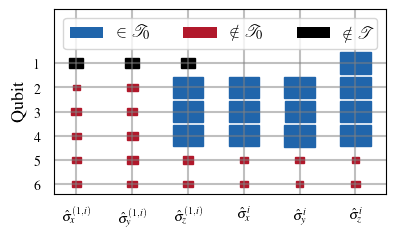

In [76]:
lf = LatexFigure(
    auto_label=False, 
    fraction=0.6, 
    font_scale=1.25
)
ax = lf.new_axis()
hinton_occurences(pivot_table, ax)
lf.save(
    os.path.join(
        save_path, 
        "nv_gen_alg_hinton.pdf"
    )
)

# Model rates

In [80]:
unique_chromosomes = pd.read_csv(
    os.path.join(run_path, "combined_datasets", "unique_chromosomes.csv")
)

models_generated =  pd.read_csv(
    os.path.join(run_path, "combined_datasets", "models_generated.csv")
)

champions_f_scores = models_generated[
    models_generated.champion==True
].f_score.values


fscore_cmap = mpl.cm.RdBu # q.growth_class.f_score_cmap
f_score_bins = list(np.arange(0, 1.01, 0.05))
bin_colours = [fscore_cmap(b) for b in f_score_bins] # or set to fixed colour for all

sampled_f_scores = pickle.load(open('sampled_f_scores_33_terms.p', 'rb'))  
regenerate_f_samples = True
n_terms = 33
true_chromosome = '001001001000000001111111111000000'
true_chromosome = np.array([
    int(i) for i  in true_chromosome
])


def rand_model_f(true_chromosome, n_terms, number_to_use=None):

    if number_to_use is None:
        r = np.random.randint(2**n_terms)
    else:
        r = number_to_use
    b = bin(r)[2:].zfill(n_terms)
    b_array = np.array([int(i) for i in list(b)])
    f = sklearn.metrics.f1_score(
        b_array, 
        true_chromosome
    )
    return f


if regenerate_f_samples:
    # sampled_f_scores = [rand_model_f(true_chromosome, n_terms) for _ in range(int(n_runs))]
    sampled_f_scores = [
        rand_model_f(true_chromosome, n_terms, i) 
        for i in range(int(1e6))
    ] # checking every model since

    pickle.dump(
        sampled_f_scores, 
        open(
            'sampled_f_scores_33_terms.p', 
            'wb'
        )
    )
print(
    "F median = {} \t std = {} from {} samples".format(
        np.round(np.median(sampled_f_scores), 3),
        np.round(np.std(sampled_f_scores), 3),
        len(sampled_f_scores)
    )
)

/home/bf16951/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


F median = 0.435 	 std = 0.115 from 1000000 samples


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


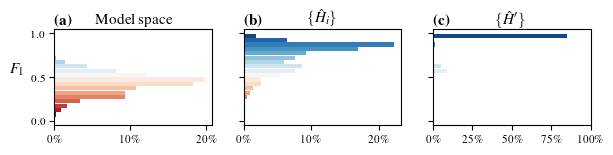

In [81]:
lf = LatexFigure(
    fraction=1,
    use_gridspec=True,
    gridspec_layout = (2,3),
    gridspec_params = {
        'height_ratios' : [1,2],
        'hspace' : 0.3, 
    }
)

# Model space
ax = lf.new_axis()
hist, bin_edges = np.histogram(
    sampled_f_scores, 
    bins = f_score_bins, 
    weights=np.ones(len(sampled_f_scores)) / len(sampled_f_scores),
)
ax.barh(
    bin_edges[:-1], 
    hist, 
    align='edge', 
    height=1/len(bin_edges),
    color=bin_colours,
)
fticks = [0, 0.25, 0.5, 0.75,  1]
fticks = [0, 0.5, 1]
ax.set_yticks(fticks)
ax.set_ylabel(r"$F_{1}$", rotation=360, labelpad=10)
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_xlabel("Model space", )
ax.xaxis.set_label_position('top')

# QMLA found models
ax = lf.new_axis()
generated_f_scores = list(unique_chromosomes.f_score.values)

hist, bin_edges = np.histogram(
    generated_f_scores,
    bins = f_score_bins,
    weights=np.ones(len(generated_f_scores)) / len(generated_f_scores),
)
ax.barh(
    bin_edges[:-1], 
    hist, 
    align='edge', 
    height=1/len(bin_edges),
    color=bin_colours,
)

ax.set_yticks(fticks)
ax.tick_params(
    labelleft=False
)
ax.set_ylabel('')
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
# ax.set_xlabel(r"$\{ \hat{H}_i \}$", labelpad=10)
ax.set_xlabel(r"$\{\hat{H}_i\}$")
ax.xaxis.set_label_position('top')

# Champion models
ax = lf.new_axis()

hist, bin_edges = np.histogram(
#     f_scores,
    champions_f_scores,
    bins = f_score_bins,
    weights=np.ones(len(champions_f_scores)) / len(champions_f_scores),
)

ax.barh(
    bin_edges[:-1], 
    hist, 
    align='edge', 
    height=1/len(bin_edges),
    color=bin_colours,
)

ax.set_yticks(fticks)
ax.tick_params(
    labelleft=False
)
ax.set_ylabel('')

ax.set_xticks([0, 0.25, 0.50, 0.75, 1])
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_xlabel(r"$\{ \hat{H}^{\prime} \}$")
ax.xaxis.set_label_position('top')

# ax = lf.new_axis(
#     span=(1,3)
# )
# hinton_occurences(pivot_table, ax)

lf.save(
    os.path.join(
        "..", "experimental_study", "figures", 
        "nv_ga_run_models_by_f.pdf"
    )    
)

# Get results as table

In [115]:
pivot_table.rename(
    columns = {
        r"$C_x$" : r"$\hat{\sigma}^{(1, i)}_x$", 
        r"$C_y$" : r"$\hat{\sigma}^{(1, i)}_y$", 
        r"$C_z$" : r"$\hat{\sigma}^{(1, i)}_z$",
        r"$R_x$" : r"$\hat{\sigma}^{i}_x$", 
        r"$R_y$" : r"$\hat{\sigma}^{i}_y$", 
        r"$R_z$" : r"$\hat{\sigma}^{i}_z$",    
    }, 
    inplace=True
)

# noramlise
pv = pivot_table/1.04
pv = pv.astype(int).abs()
pv.index = pv.index.astype(int)
pv.index.rename("Qubit", inplace=True)
pv.columns.rename('', inplace=True)
pv.loc[1, r"$\hat{\sigma}^{(1, i)}_x$"] = np.nan
pv.loc[1, r"$\hat{\sigma}^{(1, i)}_y$"] = np.nan
pv.loc[1, r"$\hat{\sigma}^{(1, i)}_z$"] = np.nan

table_path = os.path.join(
    save_path, "nv_gen_alg_term_counts.tex"
)

pv.to_latex(
    buf = table_path,
    escape=False, 
    na_rep = r"-",
    float_format="%.0f"
)